# Diversity

- This notebook intends to investigate the diversity of the [CMU Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/) dataset.
- The notebook will look at the distribution of ethnicities and gender and how it correlates with a movie's revenue.

---
**Summary**
- Diverse movies have, on average, ~27.3% higher movie box office revenue.
- Movies with the majority of male actors have, on average, ~50.9% higher movie box office revenue.
- The results are intriguing, and we would like to pursue this aspect in further analysis in milestone 3.

---
**Contents of notebook:**
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Processing" data-toc-modified-id="Data Processing">Data Processing</a></span><ul class="toc-item"><li><span><a href="#Loading-data" data-toc-modified-id="Loading data">Loading data</a></span><li><span><a href="#Removing-null-values" data-toc-modified-id="Removing null values">Removing null values</a></span></li></ul><li><span><a href="#Distributions" data-toc-modified-id="Distributions">Distributions</a></span><ul class="toc-item"><li><span><a href="#Distribution-of-release-dates" data-toc-modified-id="Distribution of release dates">Distribution of release dates</a></span></li><ul class="toc-item"><li><span><a href="#Adjusting-for-inflation" data-toc-modified-id="Adjusting for inflation">Adjusting for inflation</a></span></li></ul><li><span><a href="#Distribution-of-actors" data-toc-modified-id="Distribution of actors">Distribution of actors</a></span></li><ul class="toc-item"><li><span><a href="#Threshold" data-toc-modified-id="Threshold">Threshold</a></span></li></ul></ul></li><li><span><a href="#Ethnicity" data-toc-modified-id="Ethnicitry">Ethnicity</a></span><ul class="toc-item"><li><span><a href="#Correlation-between-the-number-of-ethnicites-and-revenue" data-toc-modified-id="Correlation between the number of ethnicites and revenue">Correlation between the number of ethnicites and revenue</a></span></li><li><span><a href="#Correlation-between-the-ethnicity-score-and-revenue" data-toc-modified-id="Correlation between the ethnicity score and revenue">Correlation between the ethnicity score and revenue</a></span></li><li><span><a href="#Difference-in-revenue-between-the-diverse-and-less-diverse-movies" data-toc-modified-id="Difference in revenue between the diverse and less diverse movies">Difference in revenue between the diverse and less diverse movies</a></span></li></ul></li><li><span><a href="#Gender" data-toc-modified-id="Gender">Gender</a></span><ul class="toc-item"><li><span><a href="#Correlation-between-the-number-of-females-and-revenue" data-toc-modified-id="Correlation between the number of females and revenue">Correlation between the number of females and revenue</a></span></li><li><span><a href="#Correlation-between-the-fraction-of-females-and-revenue" data-toc-modified-id="Correlation between the fraction of females and revenue">Correlation between the fraction of females and revenue</a></span></li><li><span><a href="#Difference-in-revenue-between-the-movies-with-majority-of-male-and-female-actors" data-toc-modified-id="Difference in revenue between the movies with majority of male and female actors">Difference in revenue between the movies with majority of male and female actors</a></span></li></ul></li></ul></div>

![Diversity](img/diversity.jpeg)

---
## Data Processing

---
### Loading data

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from helpers import bootstrap_CI, correct_for_inflation

# turn off warning
pd.options.mode.chained_assignment = None

In [2]:
# constants
MOVIE_PATH = "./data/MovieSummaries/movie.metadata.tsv"
CHARACTER_PATH = "./data/MovieSummaries/character.metadata.tsv"
RATING_PATH = "./data/IMDb/title.ratings.tsv"

In [3]:
# create dataframes

# define collumn names
colnames_movies = [
    "wikipedia_movie_ID",
    "freebase_movie_ID",
    "movie_name",
    "movie_release_date",
    "movie_box_office_revenue",
    "movie_runtime",
    "movie_languages",
    "movie_countries",
    "movie_genres",
]

colnames_character = [
    "wikipedia_movie_ID",
    "freebase_movie_ID",
    "last_update",
    "character_name",
    "actor_DOB",
    "actor_gender",
    "actor_height",
    "actor_ethnicity",
    "actor_name",
    "actor_age_at_movie_release",
    "freebase_character/actor_map_ID",
    "freebase_character_ID",
    "freebase_actor_ID",
]


# load data
movies = pd.read_csv(MOVIE_PATH, sep="\t", names=colnames_movies, header=None)
characters = pd.read_csv(
    CHARACTER_PATH, sep="\t", names=colnames_character, header=None
)

In [4]:
# print the 'movies' data frame
movies.head(1)

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."


In [5]:
movies.describe()

,wikipedia_movie_ID,movie_box_office_revenue,movie_runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


In [6]:
# print the 'characters' data frame
characters.head(1)

,wikipedia_movie_ID,freebase_movie_ID,last_update,character_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character/actor_map_ID,freebase_character_ID,freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7


---
### Removing null values
This notebook intends to investigate the correlation between diversity and revenue; we will therefore filter out movies without `Movie box office revenue.`

In [7]:
# filtering out movies without revenue
num_movies_before_filter = movies.shape[0]
movies = movies[~movies["movie_box_office_revenue"].isna()]
num_movies_after_filter = movies.shape[0]

# printing the results
print(
    f"""
Total number of movies before filtering: {num_movies_before_filter}
Number of movies after filtering:         {num_movies_after_filter}     
"""
)


Total number of movies before filtering: 81741
Number of movies after filtering:         8401     



#### Comment
- We observe that ~90% of the movies were filtered out.
- We still got 8 401 which should be sufficient for the data analysis.

---
## Distributions

---
### Distribution of release dates

In [8]:
# adding column for year release
movies["year_released"] = pd.to_datetime(
    movies["movie_release_date"], infer_datetime_format=True, errors="coerce"
).dt.year

# removing null values
movies = movies[~movies["year_released"].isna()]

# converting to 'int64'
movies["year_released"].astype("int64")

# print result
movies.head(1)

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0


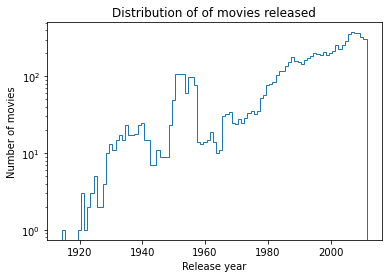

In [9]:
# plot the distribution of realese years
bins = np.arange(1915, 2013) - 0.5  # -0.5 for center-aligned bins
plt.hist(movies["year_released"], histtype="step", bins=bins, log=True)
plt.xlabel("Release year")
plt.ylabel("Number of movies")
plt.title("Distribution of of movies released")
plt.show()

#### Comment

**Problem:**
- We observe that the dataset contains some old movies. The revenue will not be representable for such movies because of inflation.


**Solution:**
- A possible solution would be to collect a dataset of the inflation since ~1920 and adjust the revenues for inflation to make them comparable.

**Conclusion:**
- We need to collect an external dataset on inflation.

---
### Adjusting for inflation

Our previous finding suggested that we had to adjust the `movie_box_office_revenue` for inflation to make movies more comparable.

In [10]:
# adjusting the 'movie_box_office_revenue' for inflation
movies = correct_for_inflation(movies, "movie_box_office_revenue", 1960, 2014)

---
### Distribution of actors

In [11]:
# add collumn for number of actors
num_actors = characters.groupby("freebase_movie_ID")["freebase_actor_ID"].apply(
    lambda x: x.count()
)

# rename the series
num_actors.name = "num_actors"

# merge with the movies data frame
movies = movies.merge(num_actors, left_on="freebase_movie_ID", right_index=True)

# print result
movies.head(1)

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,num_actors
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,2.340194e+06,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,17


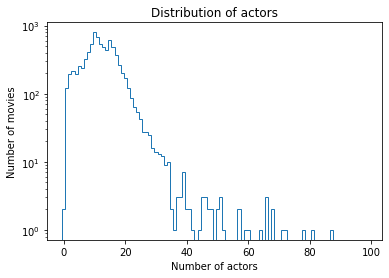

In [12]:
# plot the distribution of actors
bins = np.arange(100) - 0.5  # -0.5 for center-aligned bins
plt.hist(movies["num_actors"], histtype="step", bins=bins, log=True)
plt.xlabel("Number of actors")
plt.ylabel("Number of movies")
plt.title("Distribution of actors")
plt.show()

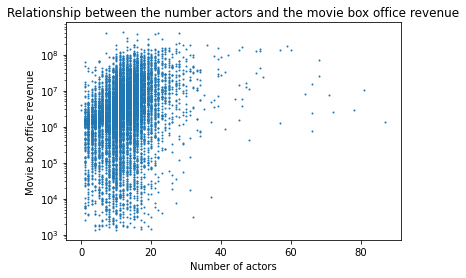

In [13]:
# plot relationship between 'num_actors' and 'movie_box_office_revenue'
movies.plot.scatter(x="num_actors", y="movie_box_office_revenue", s=1)
plt.yscale("log")
plt.xlabel("Number of actors")
plt.ylabel("Movie box office revenue")
plt.title("Relationship between the number actors and the movie box office revenue")
plt.show()

In [14]:
# compute spearman correlation between 'num_actors' and 'movie_box_office_revenue'
stats.spearmanr(movies["num_actors"], movies["movie_box_office_revenue"])

SpearmanrResult(correlation=0.36844096520080205, pvalue=4.790862071775615e-261)

#### Comment

 **Problem:**
1. We observe that many movies only have a few actors. It´s unlikely that a movie only has one actor, which is the case for ~50 movies in the dataset. The reason is probably that the dataset initially focused on characters, which can be more difficult to extract than actors.

2. We observe that movies with more actors have higher revenue. This is something to be aware of since more actors will likely provide more diversity.

**Solution:**
1. A possible solution would be to collect data about the number of actors from a different dataset. The problem with an external dataset will be finding data about ethnicity and gender. This was not included in the [IMDb datasets](https://www.imdb.com/interfaces/).

2. It will be necessary to look at the number of ethnicities and females with the total number of actors.

**Conclusion:**
1. Setting a threshold for the number of actors is a good solution that still enables us to use the original dataset.

2. Computing an `ethnicity_score` and `fraction_of_female` to also consider the total number of actors.

---
### Threshold

Our previous finding suggested that a threshold on the number of actors might be necessary.

In [15]:
# filtering out movies with less than 10 actors
num_movies_before_filter = movies.shape[0]
movies = movies[movies["num_actors"] > 9]
num_movies_after_filter = movies.shape[0]

# printing the results
print(
    f"""
Total number of movies before filtering: {num_movies_before_filter}
Number of movies after filtering:        {num_movies_after_filter}     
"""
)


Total number of movies before filtering: 8168
Number of movies after filtering:        5671     



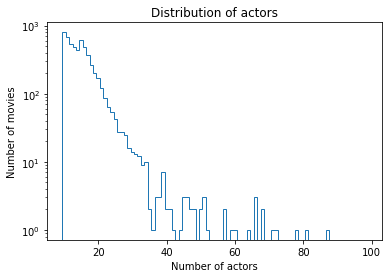

In [16]:
# plot the distribution of actors after threshold
bins = np.arange(10, 100) - 0.5  # -0.5 for center-aligned bins
plt.hist(movies["num_actors"], histtype="step", bins=bins, log=True)
plt.xlabel("Number of actors")
plt.ylabel("Number of movies")
plt.title("Distribution of actors")
plt.show()

In [17]:
# compute spearman correlation between 'num_actors' and 'movie_box_office_revenue'
stats.spearmanr(movies["num_actors"], movies["movie_box_office_revenue"])

SpearmanrResult(correlation=0.24742963052605055, pvalue=7.258673062965627e-80)

#### Comment
There is still a statistically significant correlation between `num_actors` and `movie_box_office_revenue` after introducing a threshold.

---
## Ethnicity

---
### Correlation between the number of ethnicites and revenue

In [18]:
# add collumn for number of ethnicities
num_ethnicities = characters.groupby("freebase_movie_ID")["actor_ethnicity"].apply(
    lambda x: x.nunique()
)

# rename the series
num_ethnicities.name = "num_ethnicities"

# merge with the movies data frame
movies = movies.merge(num_ethnicities, left_on="freebase_movie_ID", right_index=True)

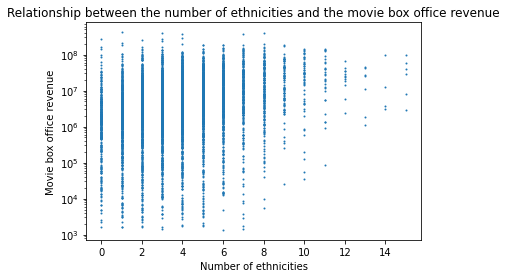

In [19]:
# plot relationship between 'num_ethnicities' and 'movie_box_office_revenue'
movies.plot.scatter(x="num_ethnicities", y="movie_box_office_revenue", s=1)
plt.yscale("log")
plt.xlabel("Number of ethnicities")
plt.ylabel("Movie box office revenue")
plt.title(
    "Relationship between the number of ethnicities and the movie box office revenue"
)
plt.show()

In [20]:
# compute spearman correlation between 'num_ethnicities' and 'movie_box_office_revenue'
stats.spearmanr(movies["num_ethnicities"], movies["movie_box_office_revenue"])

SpearmanrResult(correlation=0.29619483607782726, pvalue=3.3165951649481696e-115)

In [21]:
# compute spearman correlation between 'num_actors' and 'movie_box_office_revenue'
stats.spearmanr(movies["num_actors"], movies["movie_box_office_revenue"])

SpearmanrResult(correlation=0.24742963052605055, pvalue=7.258673062965627e-80)

#### Comment
- We observe a significant correlation between `num_ethnicities` and `movie_box_office_revenue.`
- Further, we observe that the correlation between `num_actors` and `movie_box_office_revenue` is reduced after we filtered out movies with less than ten actors. This indicates that the number of actors has the most significant impact when there are few actors, e.g., increasing from 5 to 6 will have a more substantial effect on the revenue than rising from 14 to 15.
- There is still difficult to interpret how big an impact `num_ethnicities` and `num_actors` have on `movie_box_office_revenue` separately since they are highly correlated.
- To try to isolate the impact ethnicities have on the revenue, we will instead look at an ethnicity_score, which is calculated as follow: $ethnicity\: score = \frac{number\,of\,ethnicities}{number\,of\,actors}$

---
### Correlation between the ethnicity score and revenue

In [22]:
# adding a collumn for num_etnicities / num_ectors
movies["ethnicity_score"] = movies["num_ethnicities"] / movies["num_actors"]

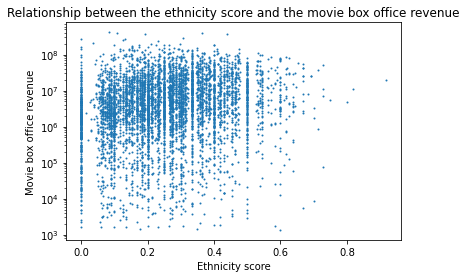

In [23]:
# plot relationship between 'ethnicity_score' and 'movie_box_office_revenue'
movies.plot.scatter(x="ethnicity_score", y="movie_box_office_revenue", s=1)
plt.yscale("log")
plt.xlabel("Ethnicity score")
plt.ylabel("Movie box office revenue")
plt.title("Relationship between the ethnicity score and the movie box office revenue")
plt.show()

In [24]:
# compute spearman correlation between 'ethnicity_score' and 'movie_box_office_revenue'
stats.spearmanr(movies["ethnicity_score"], movies["movie_box_office_revenue"])

SpearmanrResult(correlation=0.2042551070065502, pvalue=1.792002135862181e-54)

#### Comment
- After trying to isolate the impact ethnicities have on the revenue, we still observe a significant correlation.

---
### Difference in revenue between the diverse and less diverse movies

In [25]:
# check difference between the revenue of movies with an without ethnicity score above 50
over_50_revenue = movies[movies["ethnicity_score"] > 0.5]["movie_box_office_revenue"]
under_50_revenue = movies[movies["ethnicity_score"] <= 0.5]["movie_box_office_revenue"]

In [26]:
# independent t-test
stats.ttest_ind(over_50_revenue, under_50_revenue)

Ttest_indResult(statistic=1.9882743465815824, pvalue=0.04682936718007021)

In [27]:
# calculate the statistical power

# creating list to store the p-values
p_val = np.zeros(10000)

# running the simulation 10000 times
for i in range(10000):

    # sample over_50 and under_50
    sample_over_50 = np.random.choice(over_50_revenue, size=over_50_revenue.shape[0])
    sample_under_50 = np.random.choice(under_50_revenue, size=under_50_revenue.shape[0])

    # independent t-test
    p_val[i] = stats.ttest_ind(sample_over_50, sample_under_50)[1]

# calculating the percentage of rejects
power = len(p_val[p_val < 0.05]) / len(p_val)

# printing the results
print(
    f"""
The statistical power of:
    - The independent sample t-test comparing the revenue of diveres and less diverse movies: {power}
"""
)


The statistical power of:
    - The independent sample t-test comparing the revenue of diveres and less diverse movies: 0.5058



In [28]:
# calculating the mean difference
mean_diff_diversity = over_50_revenue.mean() - under_50_revenue.mean()

# performing bootstrap to get the 95% CI
diversity_CI = bootstrap_CI(over_50_revenue, under_50_revenue)

# printing the results
print(
    f"""
The mean difference between in revenue between diverse and less diverse movies:
    - Mean:                       {mean_diff_diversity}
    - CI:                         {diversity_CI}
"""
)


The mean difference between in revenue between diverse and less diverse movies:
    - Mean:                       3491585.506714709
    - CI:                         [575005.0326703031, 6540850.708689045]



In [29]:
# calculating the average revenue for under_50
mean_under_50 = under_50_revenue.mean()

# calculating the percentage difference in revenue
diff_percent = mean_diff_diversity / mean_under_50

# printing the results
diff_percent

0.2733482325968203

#### Comment 
- The independent t-test gives us a small p-value (< 0.05), which indicates a statistically significant difference between the samples of diverse (ethnicity score > 0.5) and less diverse (ethnicity score ≤ 50) movies. The statistical power of the result is 0.5058. 
- Further, the mean difference shows that diverse movies generally have higher movie box office revenue. The confidence interval makes us confident in this result. 
- By dividing the average difference by the average revenue for less diverse movies, we get that diverse movie, on average, have a ~27.3% higher movie box office revenue. This shows that ethnicity is impactful on the movie box office revenue.

---
## Gender

---
### Correlation between the number of females and revenue

In [30]:
# checkint the amount of characters without 'actor_gender'
num_characters = characters.shape[0]
num_nan_gender = characters[characters["actor_gender"].isna()].shape[0]

# printing the results
print(
    f"""
Total number of characters:                {num_characters}
Number of characters without actor gender:  {num_nan_gender}     
"""
)


Total number of characters:                450669
Number of characters without actor gender:  45609     



In [31]:
# add collumn for fraction of females

# create frame with female actors
female_characters = characters[characters["actor_gender"] == "F"]

# add column for number of female actors
num_female = female_characters.groupby("freebase_movie_ID")["actor_gender"].count()

# rename the series
num_female.name = "num_female"
movies = movies.merge(num_female, left_on="freebase_movie_ID", right_index=True)

# print result
movies.head(1)

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,num_actors,num_ethnicities,ethnicity_score,num_female
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,2.340194e+06,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,17,3,0.176471,6


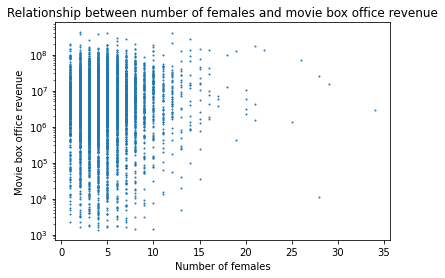

In [32]:
# plot relationship between 'num_female' and 'movie_box_office_revenue'
movies.plot.scatter(x="num_female", y="movie_box_office_revenue", s=1)
plt.yscale("log")
plt.xlabel("Number of females")
plt.ylabel("Movie box office revenue")
plt.title("Relationship between number of females and movie box office revenue")
plt.show()

In [33]:
# compute spearman correlation between 'num_female' and 'movie_box_office_revenue'
stats.spearmanr(movies["num_female"], movies["movie_box_office_revenue"])

SpearmanrResult(correlation=0.057498367351206885, pvalue=1.768401222511799e-05)

#### Comment 
- We observe a weak but significant correlation between `num_female` and `movie_box_office_revenue.`
- It is difficult to interpret how big an impact `num_female` and `num_actors` have on `movie_box_office_revenue` separately since they are highly correlated (more actors will likely lead to more female actors as well).
- To try to isolate the impact gender have on the revenue, we will instead look at the fraction of female, which is calculated as follow: $fraction\: of\: female = \frac{number\,of\,female}{number\,of\,actors}$

---
### Correlation between the fraction of females and revenue

In [34]:
# add column for fraction of females
movies["frac_female"] = movies["num_female"] / movies["num_actors"]

# print result
movies.head(1)

,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,num_actors,num_ethnicities,ethnicity_score,num_female,frac_female
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,2.340194e+06,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,17,3,0.176471,6,0.352941


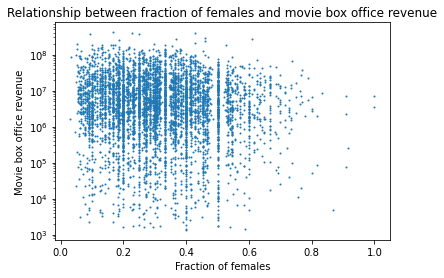

In [35]:
# plot relationship between 'frac_female' and 'movie_box_office_revenue'
movies.plot.scatter(x="frac_female", y="movie_box_office_revenue", s=1)
plt.yscale("log")
plt.xlabel("Fraction of females")
plt.ylabel("Movie box office revenue")
plt.title("Relationship between fraction of females and movie box office revenue")
plt.show()

In [36]:
# compute spearman correlation between 'frac_female' and 'movie_box_office_revenue'
stats.spearmanr(movies["frac_female"], movies["movie_box_office_revenue"])

SpearmanrResult(correlation=-0.07211486758992075, pvalue=7.205097527992801e-08)

In [37]:
# check difference between the revenue of movies with majority of men and majority of women
majority_male_revenue = movies[movies["frac_female"] <= 0.5]["movie_box_office_revenue"]
majority_female_revenue = movies[movies["frac_female"] > 0.5][
    "movie_box_office_revenue"
]

In [38]:
# independent t-test
stats.ttest_ind(majority_male_revenue, majority_female_revenue)

Ttest_indResult(statistic=3.729362998935785, pvalue=0.0001938737853779318)

#### Comment
- After trying to isolate the impact on the revenue, we still observe a significant correlation. The correlation is increased when we look at `frac_females` instead of `num_females,` but still weak.

---
### Difference in revenue between the movies with majority of male and female actors

In [39]:
# calculate the statistical power

# creating list to store the p-values
p_val = np.zeros(10000)

# running the simulation 10000 times
for i in range(10000):

    # sample over_50 and under_50
    sample_majority_male = np.random.choice(
        majority_male_revenue, size=majority_male_revenue.shape[0]
    )
    sample_majority_female = np.random.choice(
        majority_female_revenue, size=majority_female_revenue.shape[0]
    )

    # independent t-test
    p_val[i] = stats.ttest_ind(sample_majority_male, sample_majority_female)[1]

# calculating the percentage of rejects
power = len(p_val[p_val < 0.05]) / len(p_val)

# printing the results
print(
    f"""
The statistical power of:
    - The independent sample t-test comparing the revenue of movies with majority of male and majority of female 
      actors: {power}
"""
)


The statistical power of:
    - The independent sample t-test comparing the revenue of movies with majority of male and majority of female 
      actors: 0.9864



In [40]:
# calculating the mean difference
mean_diff_gender = majority_male_revenue.mean() - majority_female_revenue.mean()

# performing bootstrap to get the 95% CI
gender_CI = bootstrap_CI(majority_male_revenue, majority_female_revenue)

# printing the results
print(
    f"""
The mean difference between in revenue between diverse and less diverse movies:
    - Mean:                       {mean_diff_gender}
    - CI:                         {gender_CI}
"""
)


The mean difference between in revenue between diverse and less diverse movies:
    - Mean:                       4508179.24936687
    - CI:                         [2625456.793061592, 6161943.086081243]



In [41]:
# calculating the average revenue for under_50
mean_majority_female = majority_female_revenue.mean()

# calculating the percentage difference in revenue
diff_percent = mean_diff_gender / mean_majority_female

# printing the results
diff_percent

0.5087155591156328

#### Comment
- The independent t-test gives us a small p-value (<< 0.05), which indicates a statistically significant difference between the samples with the majority of male actors (fraction of females ≤ 0.5) and the samples with the majority of female actors (fraction of females > 50). The statistical power of 0.9864 makes us confident in this result.
- Further, the mean difference tells us that the movies with the majority of male actors generally have a higher movie box office revenue. The confidence interval makes us confident in this result. 
- By dividing the average difference by the average revenue for movies with the majority of female actors, we get that movies with the majority of male actors, on average, have a ~50.9% higher movie box office revenue. This shows that the gender-composition is impactful on the movie box office revenue.